# Astronomy 19 Final Project

Author: April Ewers

Import all required dependencies, some as aliases

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import rcParams
from matplotlib.patches import Ellipse
import astropy.io.fits
import sep

Acquire only the image data.

In [2]:
data = astropy.io.fits.getdata('./data/MAST_2025-05-25T2207/MAST_2025-05-25T2207/JWST/jw02731-o001_t017_nircam_clear-f090w/jw02731-o001_t017_nircam_clear-f090w_i2d.fits', header=False)

Display the image, and save it. I have taken the liberty of putting the brightness on a log scale so that the background formation and spikes from the stars are discernable instead of jsut the pinpoints of the stars. 

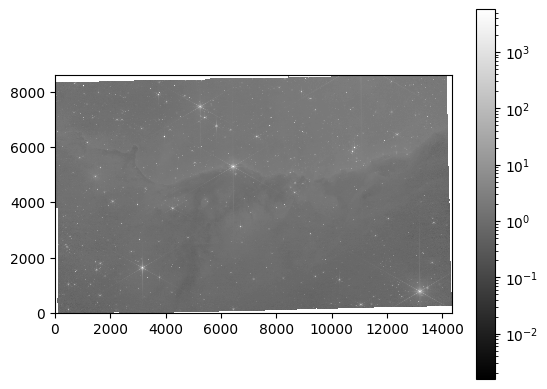

In [3]:
# show the image
plt.imshow(data, interpolation='nearest', cmap='gray', origin='lower', norm=colors.LogNorm())
plt.colorbar();

#save the image
plt.savefig('./imgs/jw02731-o001_t017_nircam_clear-f090w_i2d.png', format='png', dpi=300)

Process the image, first by setting the correct byte order and then by using sep's background function to analyze the background. That background is then shown and saved.

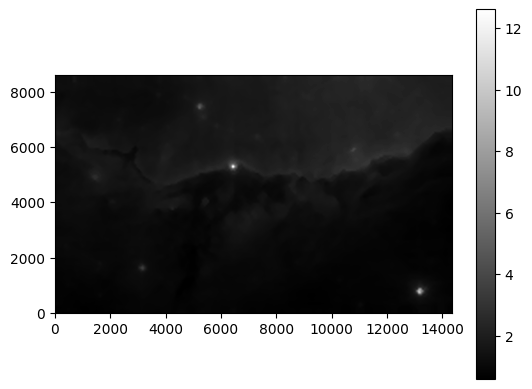

In [4]:
imgdata = data.astype(data.dtype.newbyteorder('='))
bkg = sep.Background(imgdata)
bkg_image = bkg.back()

plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

plt.savefig('./imgs/jw02731-o001_t017_nircam_clear-f090w_i2d_bkg.png', format='png', dpi=300)

The noise in the image is then analyzed, displayed, and saved.

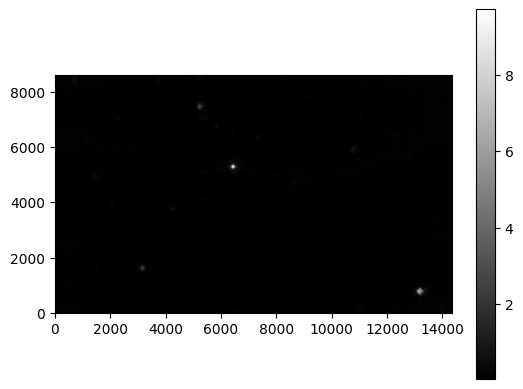

In [5]:
bkg_rms = bkg.rms()

plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

plt.savefig('./imgs/jw02731-o001_t017_nircam_clear-f090w_i2d_noise.png', format='png', dpi=300)

The background is subtracted from the image, and then the sources are analyzed with allowance for the noise found previously. The sensitivity is set fairly high due to the otherwise overwhelming number of sources. The number of sources in then output.

In [6]:
data_sub = imgdata - bkg
objects = sep.extract(data_sub, 1000, err=bkg.globalrms)

print(f"We found {objects.size} sources.")

We found 1694 sources.


The background subtracted image is shown, with the position of each source and its magnitude being used to define and place a red ellipse over it to confirm that it is identifying them correctly. This image is then saved.

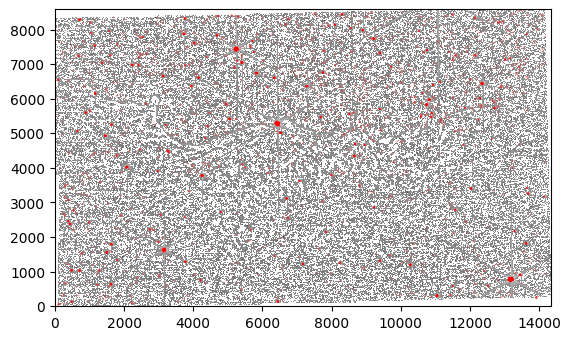

In [ ]:
# plot background-subtracted image
fig, ax = plt.subplots()
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               origin='lower', norm=colors.LogNorm())

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

plt.savefig('./imgs/jw02731-o001_t017_nircam_clear-f090w_i2d_idents.png', format='png', dpi=300)

The flux of each source is analyzed via sep's function.

In [23]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'], 1, err=bkg.globalrms, gain=1.0)

In [25]:
i = 0
for a in flux:
    if ~np.isnan(a):
        i += 1
print(i)
print(flux.size)

1581
1694


Sep's function generates Not a Number values, so these must be excised before statistical analysis can be performed.

In [28]:
flux = flux[~np.isnan(flux)]

The flux valuse are displayed.

Text(0, 0.5, 'Instances')

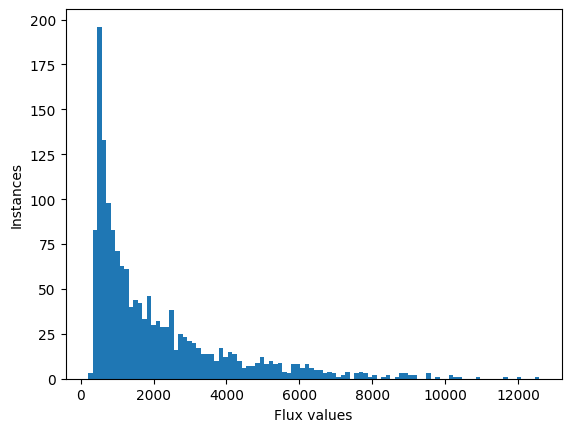

In [29]:
f, ax = plt.subplots()

ax.hist(flux, bins=100)
ax.set_xlabel("Flux values")
ax.set_ylabel("Instances")

The statistics of the flux values are analyzed and presented.

In [ ]:
print(f"The mean flux was {np.mean(flux):.7}.")
print(f"The median flux was {np.median(flux):.7}.")
print(f"The standard deviation of the flux was {np.std(flux):.7}.")
print(f"The largest outlier was {flux.max():.7}, which was positioned at ,  in the image and was {flux.max() / np.std(flux):.2} standard deviations from the mean.")

The mean flux was 2067.993.
The median flux was 1319.425.
The standard deviation of the flux was 1922.652.
The largest outlier was 12578.42, which was positioned at ,  in the image and was 6.5 standard deviations from the mean.
